### Explore grassmann distance as a metric for distance between subspaces

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils
import utils.glm_utils as glm_utils
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils

from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from models.model_wrapper import DummyCombinedWrapper
import scipy



In [2]:
# all the possible feature dimensions 
# NOTE: Capital 1st letter is the convention here
FEATURE_DIMS = ["Color", "Shape", "Pattern"]

# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"

HYAK_OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms

In [3]:
A = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]).reshape(2, 6).T
B = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]).reshape(2, 6).T
subspace_utils.calculate_grassmann_distance(A, B)

0.0

In [4]:
np.sqrt((np.pi / 2) ** 2 * 4)

3.141592653589793

### Try this out on correct vs incorrect feedback decoding

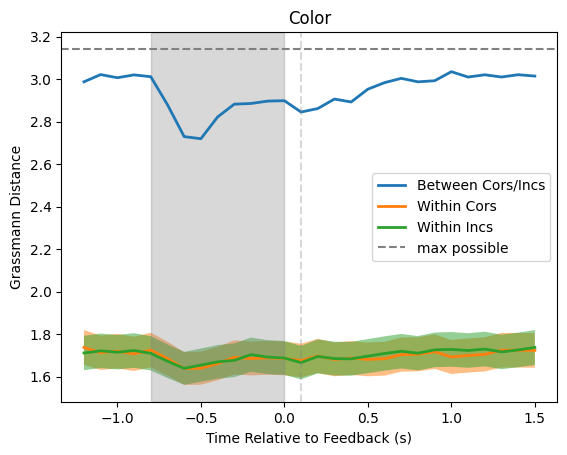

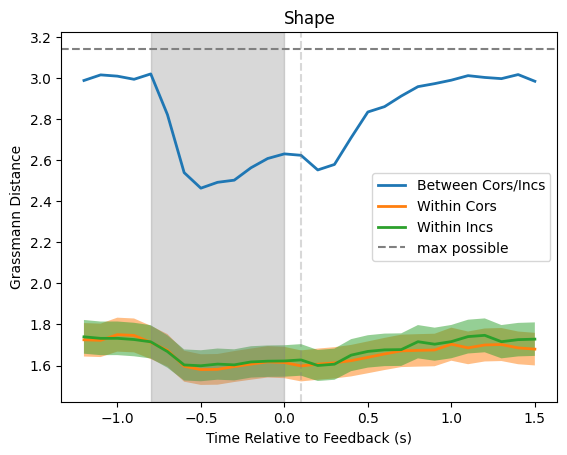

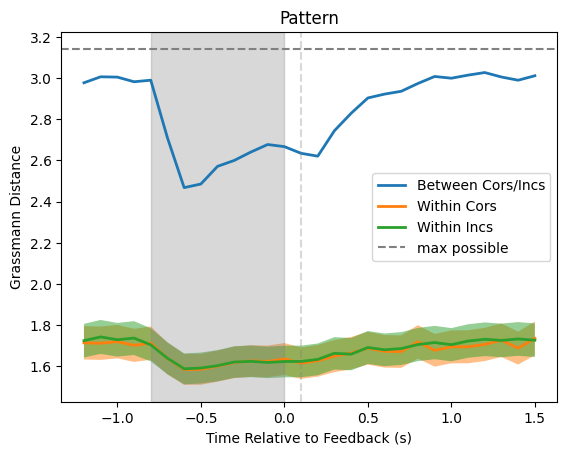

In [6]:
for feature_dim in FEATURE_DIMS:
    cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_cor_models.npy"), allow_pickle=True)
    inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_inc_models.npy"), allow_pickle=True)
    cross_distances = subspace_utils.get_distances_between_models(cor_models, inc_models)
    between_cor_distances = subspace_utils.get_distances_between_models(cor_models, cor_models)
    between_inc_distances = subspace_utils.get_distances_between_models(inc_models, inc_models)

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        cross_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Between Cors/Incs",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        between_cor_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Within Cors",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        between_inc_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Within Incs",
        right_align=True, 
        sem=True
    )
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    max = subspace_utils.get_max_grassman_distance(4)
    ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
    # add estimated chance
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Grassmann Distance")
    ax.set_title(f"{feature_dim}")
    ax.legend()

### Evaluate distances across random splits to form a baseline

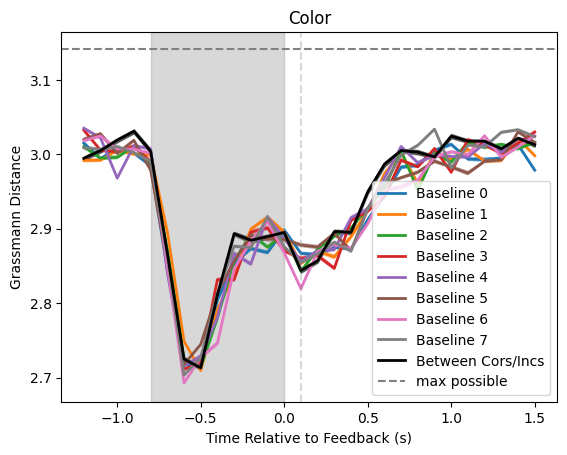

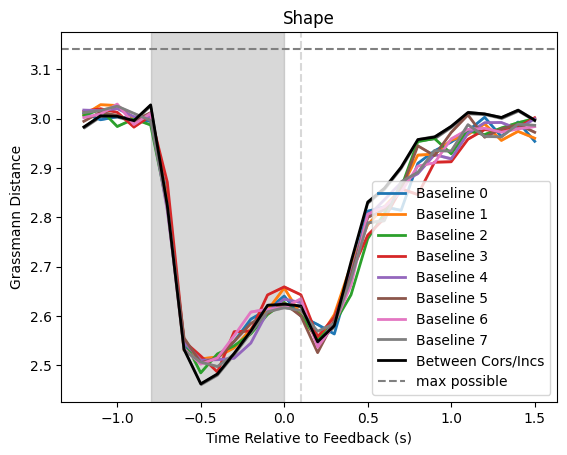

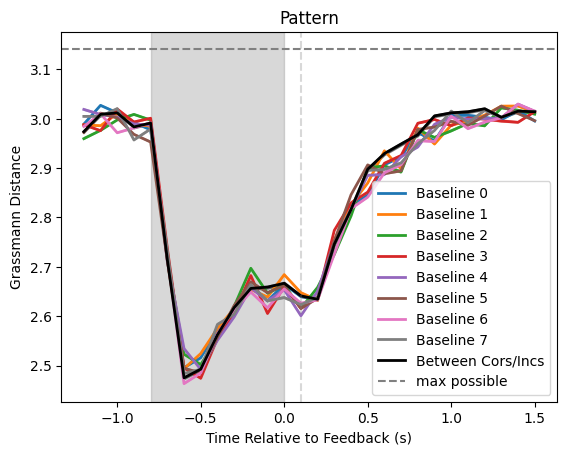

In [4]:
for feature_dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    for shuffle_idx in range(8):
        group_A_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_group_A_shuffle_{shuffle_idx}_models.npy"), allow_pickle=True)
        group_B_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_group_B_shuffle_{shuffle_idx}_models.npy"), allow_pickle=True)
        baseline_distances = subspace_utils.get_distances_between_models(group_A_models, group_B_models)
        visualization_utils.visualize_accuracy_across_time_bins(
            baseline_distances,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            ax,
            label=f"Baseline {shuffle_idx}",
            right_align=True, 
            sem=True
        )
    cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_cor_models.npy"), allow_pickle=True)
    inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_inc_models.npy"), allow_pickle=True)
    cross_distances = subspace_utils.get_distances_between_models(cor_models, inc_models)
    visualization_utils.visualize_accuracy_across_time_bins(
        cross_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Between Cors/Incs",
        right_align=True, 
        sem=True,
        color='black'
    )
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    max = subspace_utils.get_max_grassman_distance(4)
    ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
    # add estimated chance
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Grassmann Distance")
    ax.set_title(f"{feature_dim}")
    ax.legend()

        

### Look at state update subpop

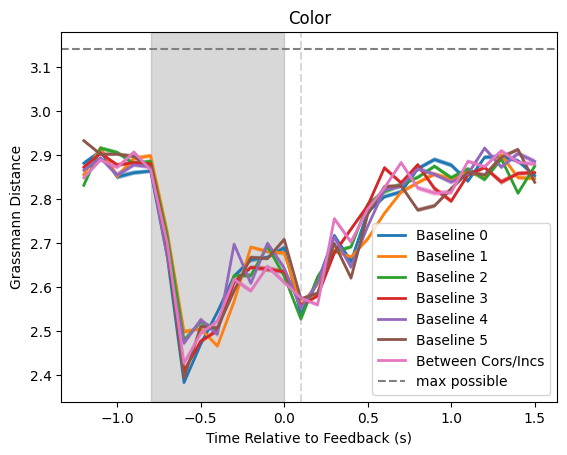

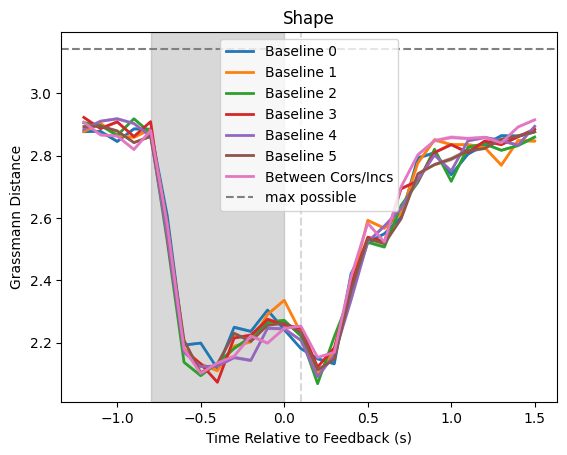

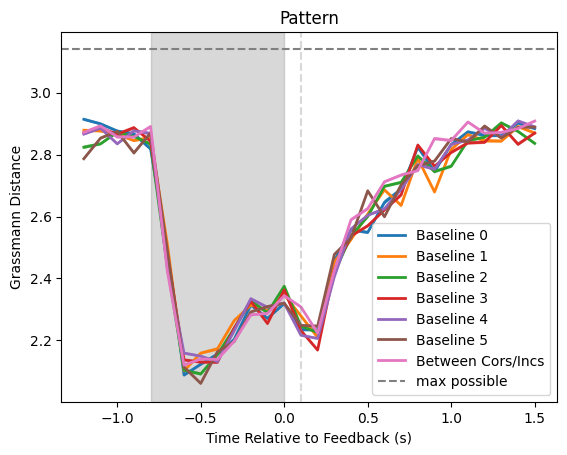

In [5]:
for feature_dim in FEATURE_DIMS:
    fig, ax = plt.subplots()
    for shuffle_idx in range(6):
        group_A_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_state_update_group_A_shuffle_{shuffle_idx}_models.npy"), allow_pickle=True)
        group_B_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_state_update_group_B_shuffle_{shuffle_idx}_models.npy"), allow_pickle=True)
        baseline_distances = subspace_utils.get_distances_between_models(group_A_models, group_B_models)
        visualization_utils.visualize_accuracy_across_time_bins(
            baseline_distances,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            ax,
            label=f"Baseline {shuffle_idx}",
            right_align=True, 
            sem=True
        )
    cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_state_update_cor_models.npy"), allow_pickle=True)
    inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_state_update_inc_models.npy"), allow_pickle=True)
    cross_distances = subspace_utils.get_distances_between_models(cor_models, inc_models)
    visualization_utils.visualize_accuracy_across_time_bins(
        cross_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Between Cors/Incs",
        right_align=True, 
        sem=True
    )
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    max = subspace_utils.get_max_grassman_distance(4)
    ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
    # add estimated chance
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Grassmann Distance")
    ax.set_title(f"{feature_dim}")
    ax.legend()

        

### See if this effect has any difference in HC and PFC groups
NOTE: This is a slightly unfair comparison since HC has less recorded neurons

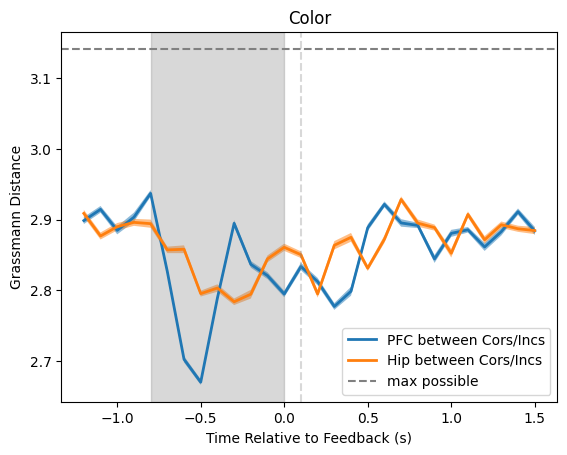

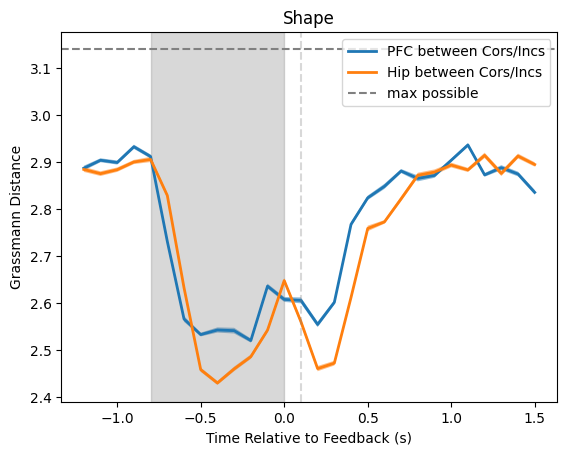

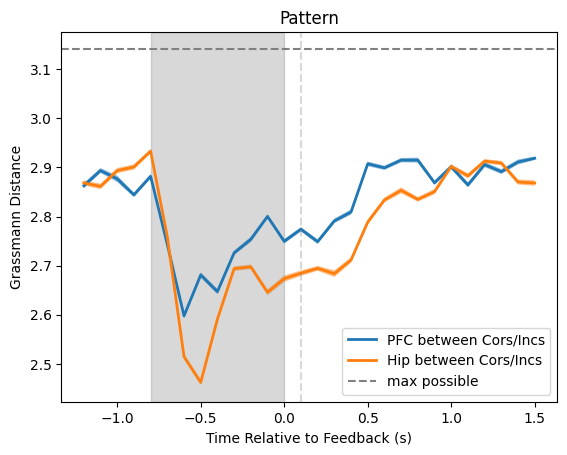

In [6]:
for feature_dim in FEATURE_DIMS:
    pfc_cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_pfc_cor_models.npy"), allow_pickle=True)
    pfc_inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_pfc_inc_models.npy"), allow_pickle=True)

    hip_cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_hip_cor_models.npy"), allow_pickle=True)
    hip_inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_hip_inc_models.npy"), allow_pickle=True)
    pfc_cross_distances = subspace_utils.get_distances_between_models(pfc_cor_models, pfc_inc_models)
    hip_cross_distances = subspace_utils.get_distances_between_models(hip_cor_models, hip_inc_models)

    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        pfc_cross_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"PFC between Cors/Incs",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        hip_cross_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Hip between Cors/Incs",
        right_align=True, 
        sem=True
    )
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    max = subspace_utils.get_max_grassman_distance(4)
    ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
    # add estimated chance
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Grassmann Distance")
    ax.set_title(f"{feature_dim}")
    ax.legend()

In [4]:
pfc_cors = []
pfc_incs = []
hip_cors = []
hip_incs = []

for feature_dim in FEATURE_DIMS:
    pfc_cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_pfc_cor_models.npy"), allow_pickle=True)
    pfc_inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_pfc_inc_models.npy"), allow_pickle=True)
    hip_cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_hip_cor_models.npy"), allow_pickle=True)
    hip_inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_hip_inc_models.npy"), allow_pickle=True)

    pfc_cors.append(pfc_cor_models)
    pfc_incs.append(pfc_inc_models)
    hip_cors.append(hip_cor_models)
    hip_incs.append(hip_inc_models)

combined_pfc_cors = DummyCombinedWrapper.combine_models(pfc_cors)
combined_pfc_incs = DummyCombinedWrapper.combine_models(pfc_incs)
combined_hip_cors = DummyCombinedWrapper.combine_models(hip_cors)
combined_hip_incs = DummyCombinedWrapper.combine_models(hip_incs)



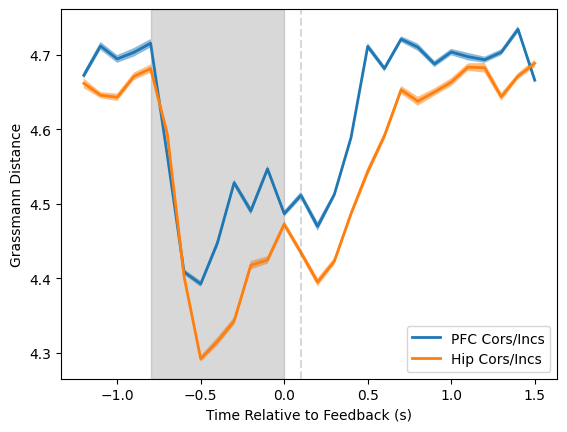

In [7]:
pfc_cross_distances = subspace_utils.get_distances_between_models(combined_pfc_cors, combined_pfc_incs)
hip_cross_distances = subspace_utils.get_distances_between_models(combined_hip_cors, combined_hip_incs)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    pfc_cross_distances,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"PFC Cors/Incs",
    right_align=True, 
    sem=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    hip_cross_distances,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Hip Cors/Incs",
    right_align=True, 
    sem=True
)
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# max = subspace_utils.get_max_grassman_distance(12)
# ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
# add estimated chance
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Grassmann Distance")
ax.legend()

### Look at distance within RPE Groups

In [1]:
for feature_dim in FEATURE_DIMS:
    less_pos_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_less_pos_models.npy"), allow_pickle=True)
    more_pos_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_more_pos_models.npy"), allow_pickle=True)
    less_neg_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_less_neg_models.npy"), allow_pickle=True)
    more_neg_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_more_neg_models.npy"), allow_pickle=True)

    within_cor_distance = subspace_utils.get_distances_between_models(less_pos_models, more_pos_models) 
    within_inc_distance = subspace_utils.get_distances_between_models(less_neg_models, more_neg_models)
    # within_high_conf_distance = get_distances_between_models(less_pos_models, more_neg_models)
    # within_low_conf_distance = get_distances_between_models(more_pos_models, less_neg_models)
    cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_cor_models.npy"), allow_pickle=True)
    inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_inc_models.npy"), allow_pickle=True)
    cross_distances = subspace_utils.get_distances_between_models(cor_models, inc_models)

    fig, ax = plt.subplots()
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     within_high_conf_distance,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Within Low Conf",
    #     right_align=True, 
    #     sem=True
    # )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     within_low_conf_distance,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Within High Conf",
    #     right_align=True, 
    #     sem=True
    # )
    visualization_utils.visualize_accuracy_across_time_bins(
        within_cor_distance,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Within Cor",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        within_inc_distance,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Within Inc",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        cross_distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Across cor/inc",
        right_align=True, 
        sem=True
    )
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    max = subspace_utils.get_max_grassman_distance(4)
    ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
    # add estimated chance
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Grassmann Distance")
    ax.set_title(f"{feature_dim}")
    ax.legend()

NameError: name 'FEATURE_DIMS' is not defined

### Now do it for the combined 12D subspace

In [30]:
all_cors = []
all_incs = []
for feature_dim in FEATURE_DIMS:
    cor_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_cor_models.npy"), allow_pickle=True)
    all_cors.append(cor_models)
    inc_models = np.load(os.path.join(HYAK_OUTPUT_DIR, f"{feature_dim}_baseline_all_inc_models.npy"), allow_pickle=True)
    all_incs.append(inc_models)
combined_cors = DummyCombinedWrapper.combine_models(all_cors)
combined_incs = DummyCombinedWrapper.combine_models(all_incs)

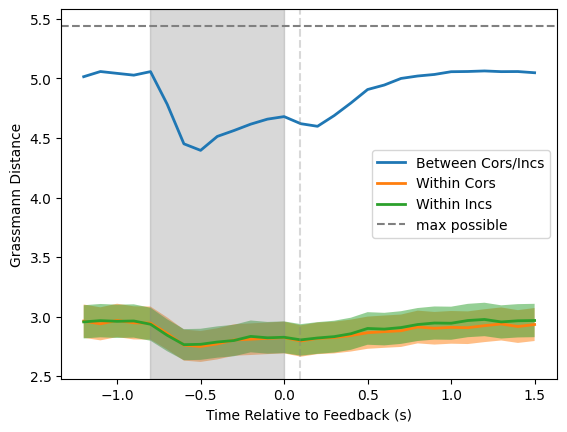

In [34]:
cross_distances = subspace_utils.get_distances_between_models(combined_cors, combined_incs)
between_cor_distances = subspace_utils.get_distances_between_models(combined_cors, combined_cors)
between_inc_distances = subspace_utils.get_distances_between_models(combined_incs, combined_incs)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    cross_distances,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Between Cors/Incs",
    right_align=True, 
    sem=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    between_cor_distances,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Within Cors",
    right_align=True, 
    sem=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    between_inc_distances,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Within Incs",
    right_align=True, 
    sem=True
)
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
max = subspace_utils.get_max_grassman_distance(12)
ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
# add estimated chance
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Grassmann Distance")
ax.legend()

### Evaluate cross distance from original feature dim decoders

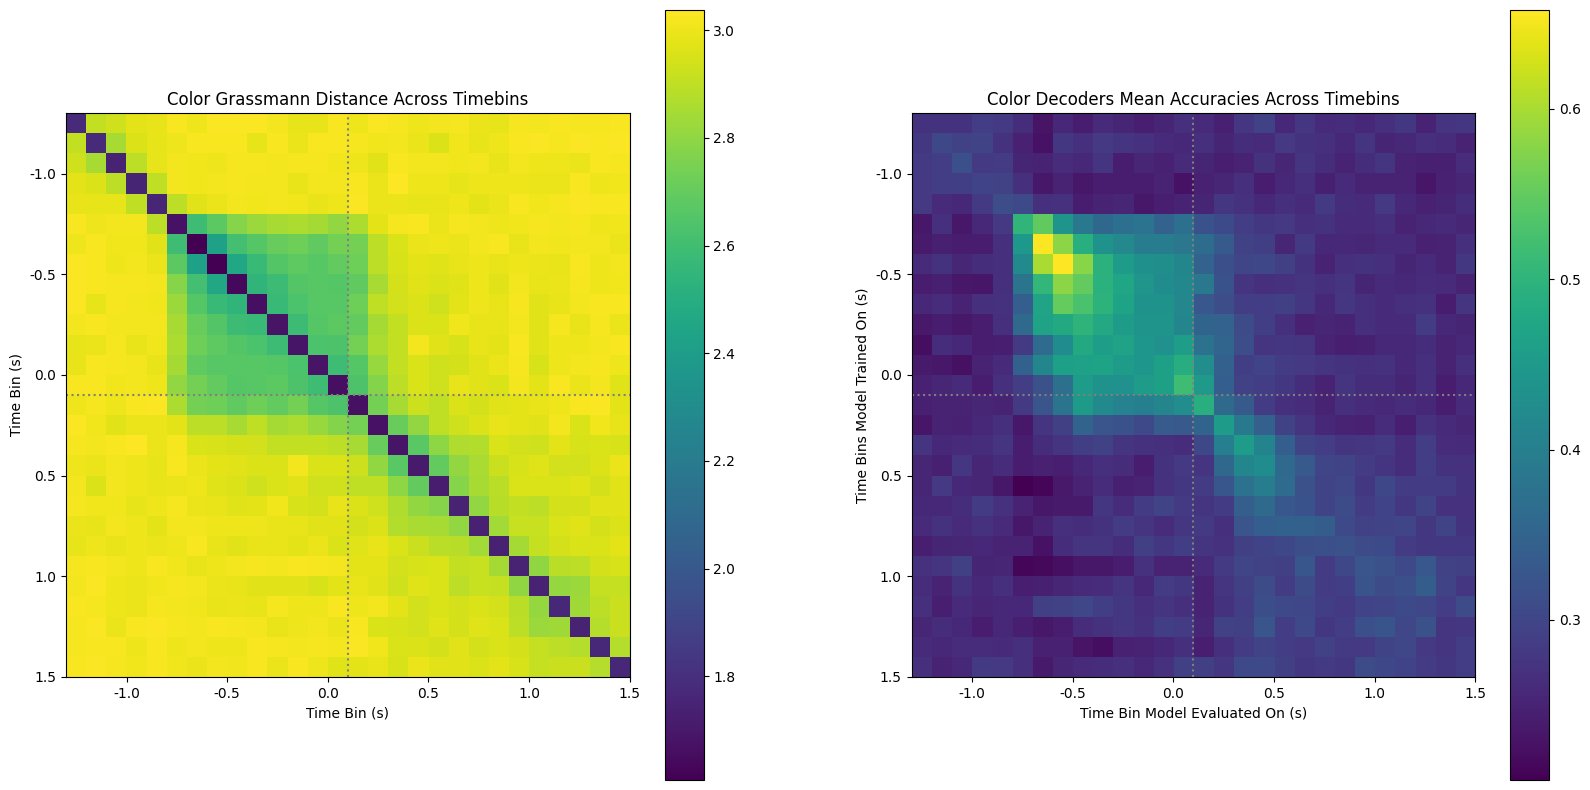

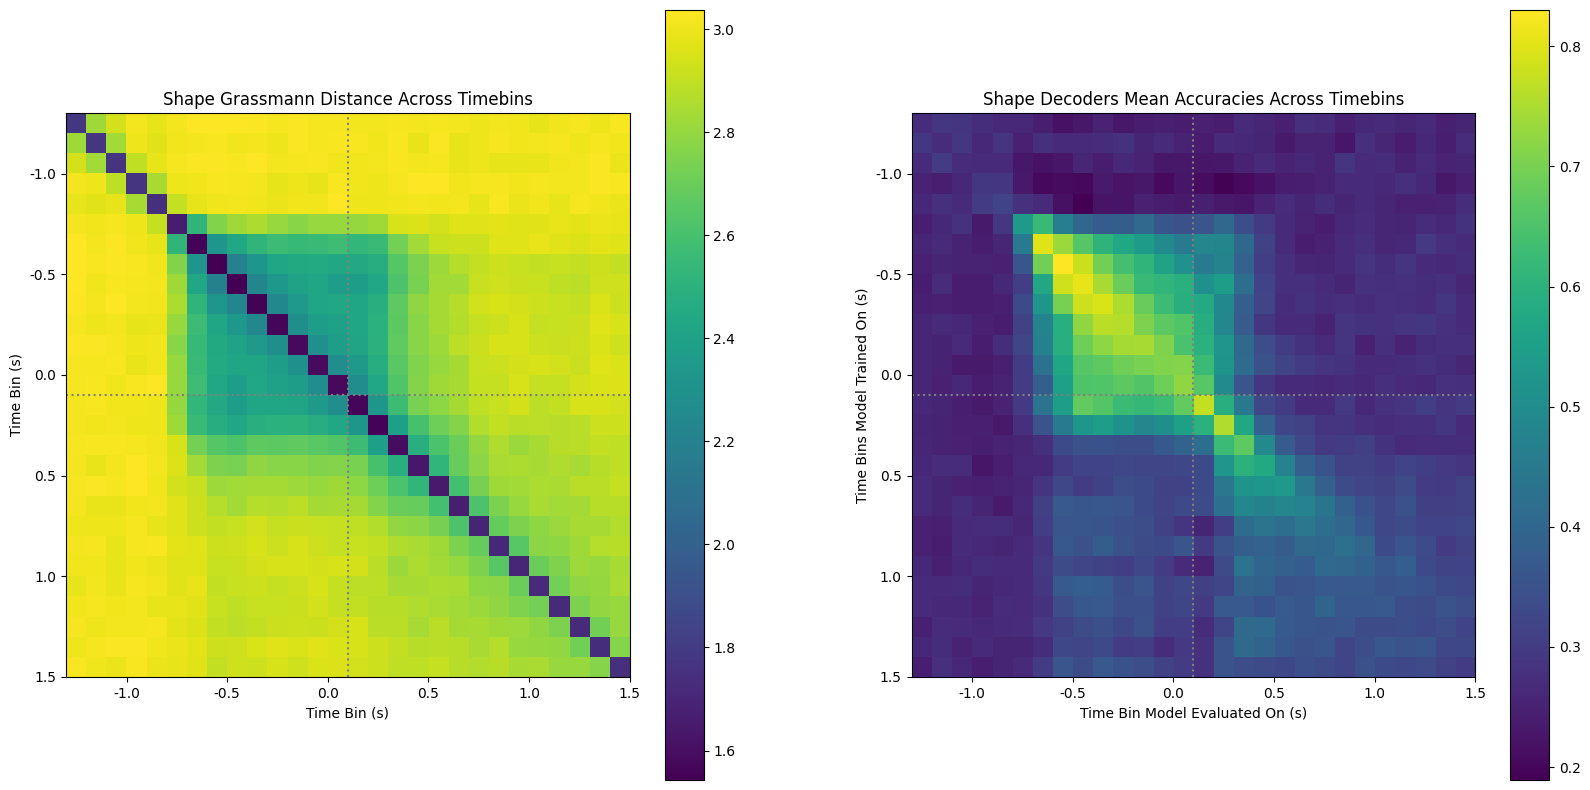

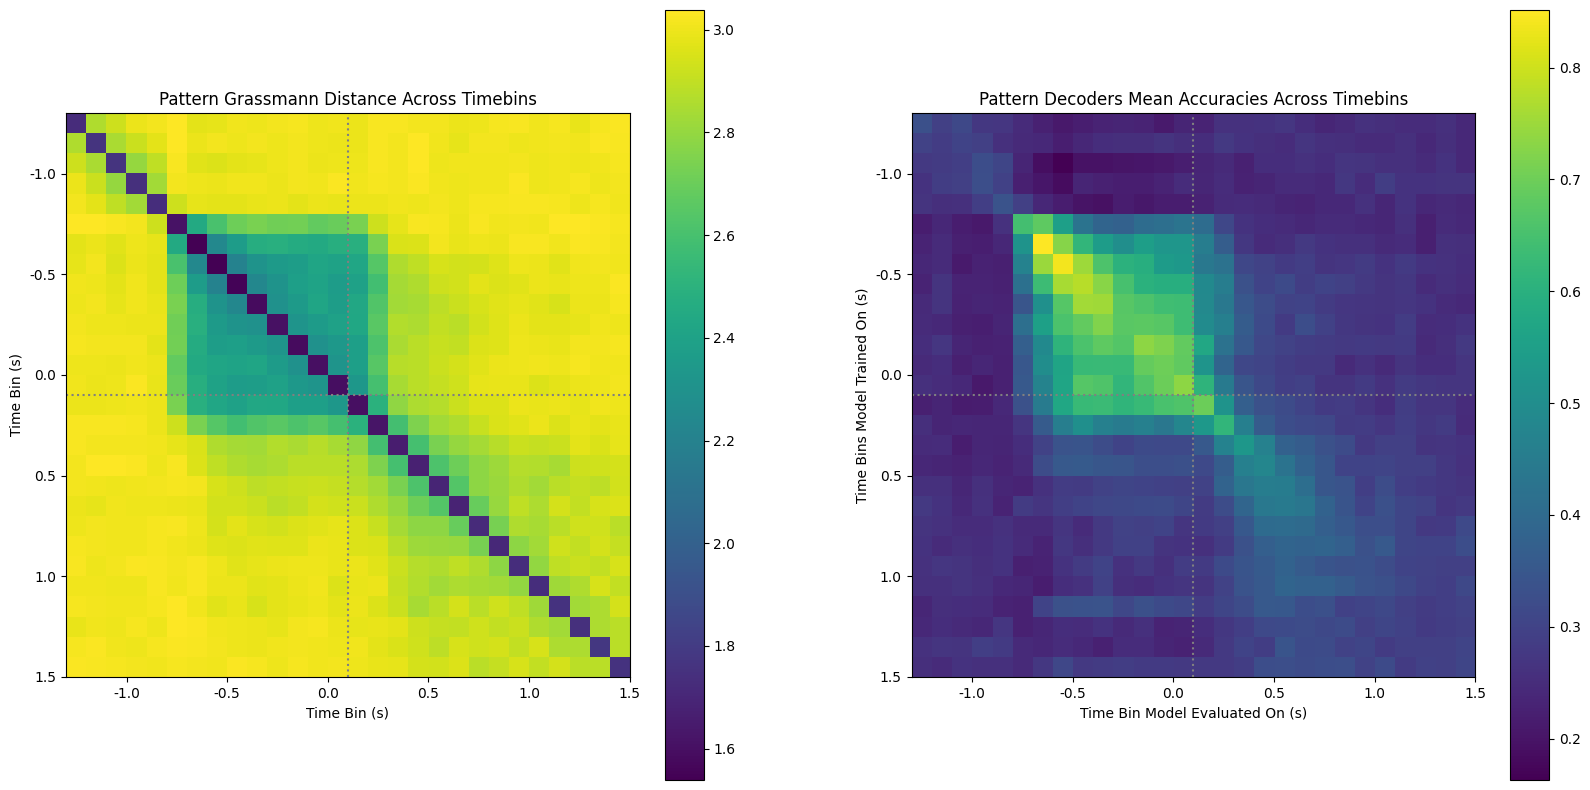

In [9]:
def show_cross(data, ax, fig):
    colors = ax.matshow(data)
    fig.colorbar(colors, ax=ax)

    ratio = 1000 / 100
    tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    tick_pos = (tick_labels + 1.3) * ratio - 0.5
    # tick_labels = np.arange(len(cross_accs))
    # tick_pos = np.arange(len(cross_accs))
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)
    ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=1.5)
    ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=1.5)


for feature_dim in FEATURE_DIMS:
    models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_models.npy"), allow_pickle=True)    
    cross_distances = get_cross_distance_for_models(models)
    cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_accs.npy"))
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    show_cross(cross_distances, ax[0], fig)
    ax[0].set_xlabel("Time Bin (s)")
    ax[0].set_ylabel("Time Bin (s)")
    ax[0].set_title(f"{feature_dim} Grassmann Distance Across Timebins")

    show_cross(cross_accs, ax[1], fig)
    ax[1].set_xlabel("Time Bin Model Evaluated On (s)")
    ax[1].set_ylabel("Time Bins Model Trained On (s)")
    ax[1].set_title(f"{feature_dim} Decoders Mean Accuracies Across Timebins")

### Take the best fixation model, at every time point, evaluate distance from selection model to fixation model

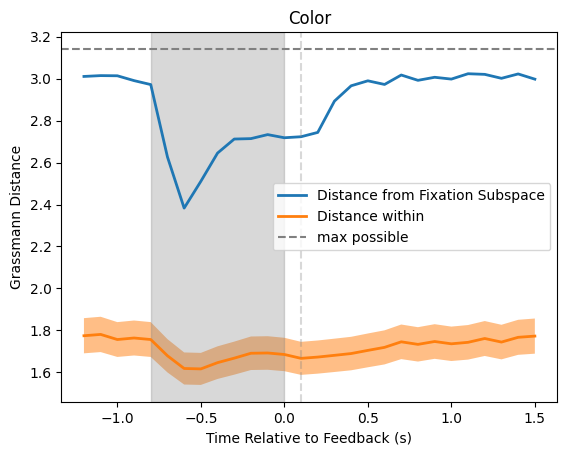

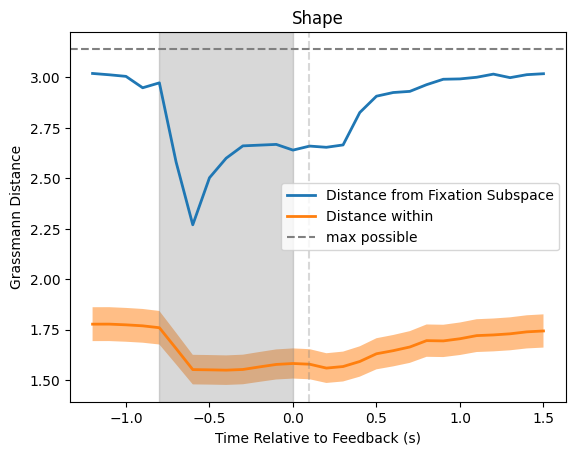

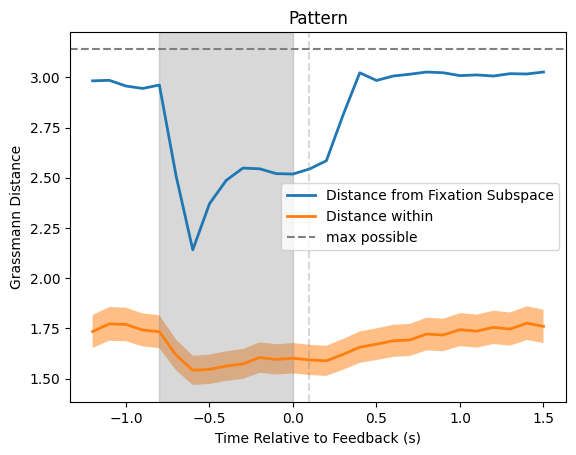

In [12]:
BEST_FIXATION_IDX = 4
for feature_dim in FEATURE_DIMS:
    fix_models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_fixations_models.npy"), allow_pickle=True)
    best_fix = fix_models[BEST_FIXATION_IDX, :]
    models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_models.npy"), allow_pickle=True)
    distances = []
    for time_idx in range(models.shape[0]):
        distances.append(subspace_utils.get_distances_between_splits(best_fix, models[time_idx, :]))
    distances = np.array(distances)
    within_models = subspace_utils.get_distances_between_models(models, models)
    fig, ax = plt.subplots()
    visualization_utils.visualize_accuracy_across_time_bins(
        distances,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Distance from Fixation Subspace",
        right_align=True, 
        sem=True
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        within_models,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Distance within",
        right_align=True, 
        sem=True
    )
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    max = subspace_utils.get_max_grassman_distance(4)
    ax.axhline(max, color='gray', linestyle='dashed', label="max possible")
    # add estimated chance
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Grassmann Distance")
    ax.set_title(f"{feature_dim}")
    ax.legend()